# Understand ADC vs SCC model

In [1]:
import os
import sys
import random
import re
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cv2

# import self-defined image processing functions
from segmentation_functions import *

# import some image processing functions for dataset augmentation
from PIL import Image
import scipy
from scipy import ndimage

In [2]:
RGB_MARKERS = {
    'BG': [255, 255, 255],  # Background
    'Tumor': [0, 255, 0],  # Tumor
    'Stroma': [255, 0, 0],  # Stroma
    'Lymphocyte': [0, 0, 255],  # Lymphocyte
    'Blood': [255, 0, 255],  # Blood cell
    'Macrophage': [255, 255, 0],  # Macrophage
    'Karyorrhexis': [0, 148, 255]  # Dead nuclei
}

CLASSES = ['BG', 'Tumor', 'Stroma', 'Lymphocyte', 'Blood', 'Macrophage', 'Karyorrhexis']

In [3]:
MEAN = [149.91262888, 125.60738922, 155.41683322]
STD = [64.47969016, 65.98274776, 53.71798459]

# 1) Visualize graph values in each layer

In [4]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn.neighbors as skgraph
from scipy import sparse as sp
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, NNConv, global_max_pool, global_mean_pool
from torch_geometric.data import Data
from torch_scatter import scatter_mean

In [5]:
x_ave = np.array([2.62e+02, 2.76e+02, # area, convex_area, 
                   7.44e-01, 7.02e-01, 2.62e+02, 2.32e+01,  # eccentricity, extent, filled_area, major_axis_length
                   1.32e+01, 1.54e+01, 5.97e+01, 8.63e-01,  # minor_axis_length, pa_ratio, perimeter, probability
                   9.52e-01])  # solidity

x_std = np.array([2.34e+02, 2.49e+02,  # area, convex_area,
                   1.61e-01, 1.04e-01, 2.34e+02, 1.13e+01,  # eccentricity, extent, filled_area, major_axis_length
                   5.31e+00, 4.07e+00, 2.76e+01, 7.25e-02,  # minor_axis_length, pa_ratio, perimeter, probability
                   3.78e-02])   # solidity

In [6]:
nlst_adc_data_dir = "/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/nuclei_segmentation/output/NLST_ADC_100_patches_updated"
nlst_scc_data_dir = "/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/nuclei_segmentation/output/NLST_SCC_100_patches"
tcga_luad_data_dir = "/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/nuclei_segmentation/output/TCGA_LUAD_100_patches_updated"
tcga_lusc_data_dir = "/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/nuclei_segmentation/output/TCGA_LUSC_100_patches"

In [7]:
nlst_adc_slide_dir = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC"
nlst_scc_slide_dir = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_SCC/images"
tcga_scc_slide_dir = "/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/TCGA_LUSC/images/"

In [8]:
class NucleiData(Data):
    """Add some attributes to Data object.
    
    Args:
        * All args mush be torch.tensor. So string is not supported.
        x: Matrix for nodes
        cell_type: cell type
        edge_index: 2*N matrix
        edge_attr: edge types
        y: Label
        pid: Patient ID
        region_id: Region ID, range from 0~99
    """
    def __init__(self, x=None, cell_type=None, edge_index=None, edge_attr=None, y=None, pos=None, pid=None, region_id=None):
        super().__init__(x, edge_index, edge_attr, y, pos)
        self.cell_type = cell_type
        self.pid = pid
        self.region_id = region_id
        
    def __repr__(self):
        info = ['{}={}'.format(key, self.size_repr(item)) for key, item in self]
        return '{}({})'.format(self.__class__.__name__, ', '.join(info))
    
    @staticmethod
    def size_repr(value):
        if torch.is_tensor(value):
            return list(value.size())
        elif isinstance(value, int) or isinstance(value, float) or isinstance(value, str):
            return [1]
        else:
            raise ValueError('Unsupported attribute type.')
            
def get_edge_type(edge, cell_type):
    """
    Args: 
        edge: (in_cell_index, out_cell_index, 1/edge_length)
        
    Returns:
        edge type index.
        0: 1-1; 1: 1-2; 2: 1-3; 3: 1-4; 4: 1-5; 5: 1-6
        6: 2-1; 7: 2-2; 8: 2-3; 9: 2-4; 10: 2-5; 11: 2-6
        12: 3-1; 13: 3-2; 14: 3-3; 15: 3-4; 16: 3-5; 17: 3-6
        18: 4-1; 19: 4-2; 20: 4-3; 21: 4-4; 22: 4-5; 23: 4-6
        24: 5-1; 25: 5-2; 26: 5-3; 27: 5-4; 28: 5-5; 29: 5-6
        30: 6-1; 31: 6-2; 32: 6-3; 33: 6-4; 34: 6-5; 35: 6-6
    """
    mapping = {"1-1": 0, "1-2": 1, "1-3": 2, "1-4": 3, "1-5": 4, "1-6": 5,
                   "2-1": 6, "2-2": 7, "2-3": 8, "2-4": 9, "2-5": 10, "2-6": 11,
                   "3-1": 12, "3-2": 13, "3-3": 14, "3-4": 15, "3-5": 16, "3-6": 17,
                   "4-1": 18, "4-2": 19, "4-3": 20, "4-4": 21, "4-5": 22, "4-6": 23,
                   "5-1": 24, "5-2": 25, "5-3": 26, "5-4": 27, "5-5": 28, "5-6": 29,
                   "6-1": 30, "6-2": 31, "6-3": 32, "6-4": 33, "6-5": 34, "6-6": 35}
    return mapping['{}-{}'.format(cell_type[edge[0]], cell_type[edge[1]])]

def get_nuclei_orientation_diff(edge, nuclei_orientation):
    return np.cos(nuclei_orientation[edge[0]] - nuclei_orientation[edge[1]])

In [9]:
class EdgeNN(nn.Module):
    """
    Design: embedding according to edge type, and then modulated by edge features.
    """
    def __init__(self, in_channels, out_channels, n_edge_types=36):
        super(EdgeNN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.edge_type_embedding = nn.Embedding(n_edge_types, out_channels)
        self.fc_h = nn.Linear(in_channels, out_channels)
        self.fc_g = nn.Linear(in_channels, out_channels)
        
    def forward(self, x):
        """
        Args:
            x: [batch_size, n_edges, 1(edge type) + in_channels]
        
        return: [batch_size, out_channels]
        """
        y = self.edge_type_embedding(x[..., 0].clone().detach().type(torch.long).to(device))
        h = self.fc_h(x[..., 1:(self.in_channels + 1)].clone().detach().type(torch.float).to(device))
        g = self.fc_g(x[..., 1:(self.in_channels + 1)].clone().detach().type(torch.float).to(device))
        y = y * h + g
        return F.relu(y, inplace=True)

class NucleiNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels, batch=True, edge_features=2, n_edge_types=36):
        """
        Args:
            in_channels: No. of node features
            out_channels: No. of output node features (e.g., No. classes for classification)
            batch: True if from DataLoader; False if single Data object
            edge_features: No. of edge features (excluding edge type)
            n_edge_types: No. of edge types
        """
        super(NucleiNet, self).__init__()
        self.batch=batch
        
        self.conv1 = NNConv(in_channels, 10, EdgeNN(edge_features, in_channels*10, n_edge_types=n_edge_types), 
                            aggr='mean', root_weight=True, bias=True)
        self.conv2 = NNConv(10, 10, EdgeNN(edge_features, 10*10, n_edge_types=n_edge_types), 
                            aggr='mean', root_weight=True, bias=True)
        self.conv3 = NNConv(10, out_channels, EdgeNN(edge_features, 10*out_channels, n_edge_types=n_edge_types), 
                            aggr='mean', root_weight=True, bias=True)
        
    def forward(self, data):
        """
        Args:
            data: Data in torch_geometric.data
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index, edge_attr)
        x = F.relu(x)
        '''
        if self.batch:
            x = global_max_pool(x, batch=data.batch).to(device)
        else:
            x = global_max_pool(x, batch=torch.tensor(np.zeros(x.shape[0]), dtype=torch.long).to(device))
        '''
        # cell_type = data.cell_type
        # gate = data.cell_type
        gate = torch.eq(data.cell_type, 1).clone().detach().requires_grad_(False).type(torch.long).to(device)
        # print(np.unique(data.batch.cpu().numpy()))  ## [0, 1, 2, ... BATCH_SIZE-1]
        # print(gate * data.batch)  ## [[0]s, [1]s, .... [BATCH_SIZE - 1]s]
        if self.batch:
            _batch_size = data.batch[-1] + 1
            x = scatter_mean(x, gate * (data.batch+1), dim=0).to(device)[1:_batch_size+1, :]  # Keep the batches
            # print(x.shape)  ## [BATCH_SIZE, 2]
        else:
            x = scatter_mean(x, gate, dim=0).to(device)[1, :]
            # print(x.shape)  ## [2]
        
        return x

In [10]:
global device
device = 'cpu'

In [11]:
model = NucleiNet(11, 2, batch=False)
model.to(device)
model.load_state_dict(torch.load("./models/cell_graph_ADC_vs_SCC_2_11042019/epoch_285.pt", 
                                 map_location=device))
model.eval()

NucleiNet(
  (conv1): NNConv(11, 10)
  (conv2): NNConv(10, 10)
  (conv3): NNConv(10, 2)
)

In [12]:
class NucleiNetConv3(torch.nn.Module):
    def __init__(self, in_channels, out_channels, batch=True, edge_features=2, n_edge_types=36):
        """
        Args:
            in_channels: No. of node features
            out_channels: No. of output node features (e.g., No. classes for classification)
            batch: True if from DataLoader; False if single Data object
            edge_features: No. of edge features (excluding edge type)
            n_edge_types: No. of edge types
        """
        super(NucleiNetConv3, self).__init__()
        self.batch=batch
        
        self.conv1 = NNConv(in_channels, 10, EdgeNN(edge_features, in_channels*10, n_edge_types=n_edge_types), 
                            aggr='mean', root_weight=True, bias=True)
        self.conv2 = NNConv(10, 10, EdgeNN(edge_features, 10*10, n_edge_types=n_edge_types), 
                            aggr='mean', root_weight=True, bias=True)
        self.conv3 = NNConv(10, out_channels, EdgeNN(edge_features, 10*out_channels, n_edge_types=n_edge_types), 
                            aggr='mean', root_weight=True, bias=True)
        
    def forward(self, data):
        """
        Args:
            data: Data in torch_geometric.data
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index, edge_attr)
        x = F.relu(x)
        return x

In [13]:
model_conv3 = NucleiNetConv3(11, 2, batch=False)
model_conv3.to(device)
model_conv3.load_state_dict(
        torch.load("./models/cell_graph_ADC_vs_SCC_2_11042019/epoch_285.pt",
        map_location=device),
    strict=True)
model_conv3.eval()

NucleiNetConv3(
  (conv1): NNConv(11, 10)
  (conv2): NNConv(10, 10)
  (conv3): NNConv(10, 2)
)

### Visualize an ADC slide

/home2/swan15/.conda/envs/mask_rcnn_danni/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


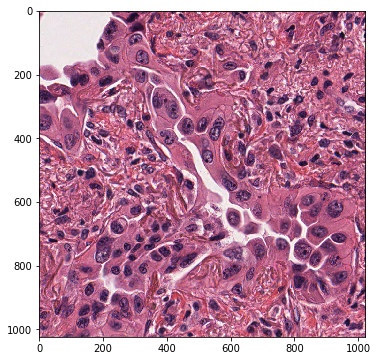

array([12.326099,  5.935061], dtype=float32)

In [14]:
pid = 0
i = 0
slide_id = "10862.svs"
patch_id = 90

# Read image patch & nuclei
cell_summary = pd.read_csv(os.path.join(nlst_adc_data_dir, slide_id, "cell_summary_40X_100patches.csv"))
patch_summary = cell_summary[cell_summary['n_patch'] == patch_id]
patch_coords = pd.read_csv(os.path.join(nlst_adc_data_dir, slide_id, "patch_summary_40X_100patches.csv"))

# Plot image
slide_file = os.path.join("/archive/DPDS/Xiao_lab/shared/hudanyun_sheng/pathology_image_data/NLST_ADC", slide_id)
image = extract_patch_by_location(slide_file, 
                                  location=(patch_coords['coordinate_x'][patch_id], 
                                            patch_coords['coordinate_y'][patch_id]),
                                  patch_size=(1024, 1024))
image = np.array(image)[..., :3]

# Plot nuclei
coord_x, coord_y = patch_coords.ix[patch_id, ["coordinate_x", "coordinate_y"]].values
coordinate_x = patch_summary['coordinate_x'] - patch_coords['coordinate_x'][patch_id]
coordinate_y = patch_summary['coordinate_y'] - patch_coords['coordinate_y'][patch_id]

mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolor = mycolors[patch_summary['cell_type'] - 1]

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

# Construct graph data
if len(patch_summary['cell_type'] == 1) < 20:
    raise Exception("Too few tumor cells.")

# Create 8 nearest neighbors graph
graph = skgraph.kneighbors_graph(np.array(patch_summary.loc[:, ['coordinate_x', 'coordinate_y']]), 
                                 n_neighbors=8, mode='distance')
I, J, V = sp.find(graph)
edges = list(zip(I, J, 1/V))
edge_index = np.transpose(np.array(edges)[:, 0:2])
x = (np.array(patch_summary.loc[:, ['area', 'convex_area', 
                                   'eccentricity', 'extent', 'filled_area', 
                                    'major_axis_length', 'minor_axis_length', 'pa_ratio', 
                                    'perimeter', 'probability', 'solidity']]) - x_ave)/x_std
cell_type = np.array(patch_summary['cell_type'])
orientation = np.array(patch_summary['orientation'])

# Edge features
edge_type = list(map(lambda x: get_edge_type(x, cell_type), edges))
nuclei_orientation = list(map(lambda x: get_nuclei_orientation_diff(x, orientation), edges))
edge_attr = np.transpose(np.array([edge_type, nuclei_orientation, 1/V]))

data = NucleiData(x=torch.tensor(x, dtype=torch.float), 
                  cell_type=torch.tensor(cell_type, dtype=torch.long),
                  edge_index=torch.tensor(edge_index, dtype=torch.long),
                  edge_attr=torch.tensor(edge_attr, dtype=torch.float),
                  y=torch.tensor([[0]]),
                  pid=torch.tensor([[i]]),
                  region_id=torch.tensor([[patch_id]]))

# data.x = torch.zeros_like(data.x) + 1

model(data.to(device)).detach().cpu().numpy().squeeze()

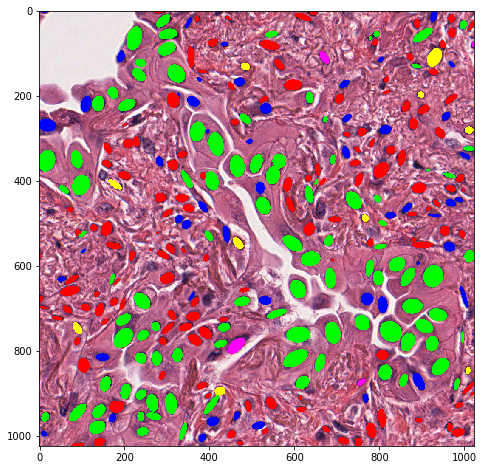

In [15]:
# Reconstruct segmentation
h, w = 1024, 1024
# mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolors = np.array([[0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 0, 255], [255, 255, 0], [0, 255, 255]])
roi_pred_image = image.copy()
for index, (_, cell) in enumerate(patch_summary.iterrows()):
    y, x = skimage.draw.ellipse(cell['coordinate_x'] - patch_coords['coordinate_x'][patch_id], 
                                cell['coordinate_y'] - patch_coords['coordinate_y'][patch_id], 
                                cell['major_axis_length']/2, cell['minor_axis_length']/2, 
                                rotation=-cell['orientation'])
    c = np.logical_and.reduce([x>0, x<h, y>0, y<w])
    x, y = x[c], y[c]
    roi_pred_image[x, y, :] = mycolors[int(cell['cell_type'] - 1)]
    
plt.figure(figsize=(8, 8))
plt.imshow(roi_pred_image)
plt.show()

In [16]:
# Calculate and plot risk score
cell_ADC_scores = model_conv3(data.to(device)).detach().cpu().numpy().squeeze()[:, 0]
print(min(cell_ADC_scores), max(cell_ADC_scores))

2.628009 40.2616


0.00016279242 1.0


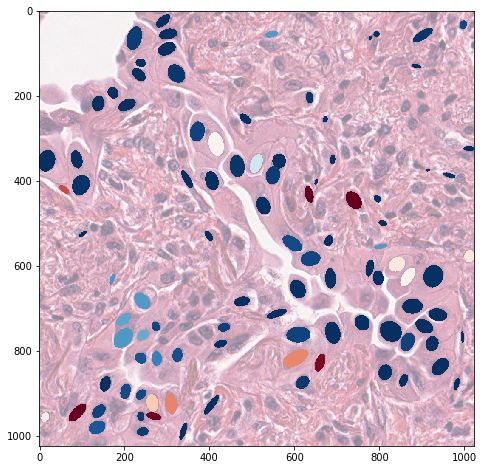

In [17]:
## Plot adc prob.

# Calculate and plot risk score
cell_ADC_scores = torch.softmax(model_conv3(data.to(device)).detach().cpu(), dim=1).numpy().squeeze()[:, 0]
print(min(cell_ADC_scores), max(cell_ADC_scores))

# Set color
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colorbar import ColorbarBase

vmax = 1

norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cmap = cm.RdBu
# cmap = mycmap  # cm.summer
m = cm.ScalarMappable(norm=norm, cmap=cmap)
mycolor_risk = m.to_rgba(cell_ADC_scores)

# Set non-tumor cell types to transparent
mycolor_risk[cell_type != 1, :] = [0, 0, 0, 0]

# Reconstruct segmentation
h, w = 1024, 1024
# mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolors = np.array([[0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 0, 255], [255, 255, 0], [0, 255, 255]])
# roi_pred_image = image.copy()
alpha = 0.5
roi_pred_image = (image * alpha + (np.zeros_like(image).astype(np.uint8) + 255) * (1 - alpha)).astype(np.uint8)
for index, (_, cell) in enumerate(patch_summary.iterrows()):
    if cell['cell_type'] == 1:
        y, x = skimage.draw.ellipse(cell['coordinate_x'] - patch_coords['coordinate_x'][patch_id], 
                                    cell['coordinate_y'] - patch_coords['coordinate_y'][patch_id], 
                                    cell['major_axis_length']/2, cell['minor_axis_length']/2, 
                                    rotation=-cell['orientation'])
        c = np.logical_and.reduce([x>0, x<h, y>0, y<w])
        x, y = x[c], y[c]
        roi_pred_image[x, y, :] = mycolor_risk[index][:3] * 255
    
plt.figure(figsize=(8, 8))
plt.imshow(roi_pred_image)
plt.show()

### Another ADC slide

In [18]:
pid = 0
i = 0
slide_id = "9388.svs"
patch_id = 9

# Read image patch & nuclei
cell_summary = pd.read_csv(os.path.join(nlst_adc_data_dir, slide_id, "cell_summary_40X_100patches.csv"))
patch_summary = cell_summary[cell_summary['n_patch'] == patch_id]
patch_coords = pd.read_csv(os.path.join(nlst_adc_data_dir, slide_id, "patch_summary_40X_100patches.csv"))

# Plot image
slide_file = os.path.join(nlst_adc_slide_dir, slide_id)
image = extract_patch_by_location(slide_file, 
                                  location=(patch_coords['coordinate_x'][patch_id], 
                                            patch_coords['coordinate_y'][patch_id]),
                                  patch_size=(1024, 1024))
image = np.array(image)[..., :3]

# Plot nuclei
coord_x, coord_y = patch_coords.ix[patch_id, ["coordinate_x", "coordinate_y"]].values
coordinate_x = patch_summary['coordinate_x'] - patch_coords['coordinate_x'][patch_id]
coordinate_y = patch_summary['coordinate_y'] - patch_coords['coordinate_y'][patch_id]

mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolor = mycolors[patch_summary['cell_type'] - 1]

# Construct graph data
if len(patch_summary['cell_type'] == 1) < 20:
    raise Exception("Too few tumor cells.")

# Create 8 nearest neighbors graph
graph = skgraph.kneighbors_graph(np.array(patch_summary.loc[:, ['coordinate_x', 'coordinate_y']]), 
                                 n_neighbors=8, mode='distance')
I, J, V = sp.find(graph)
edges = list(zip(I, J, 1/V))
edge_index = np.transpose(np.array(edges)[:, 0:2])
x = (np.array(patch_summary.loc[:, ['area', 'convex_area', 
                                   'eccentricity', 'extent', 'filled_area', 
                                    'major_axis_length', 'minor_axis_length', 'pa_ratio', 
                                    'perimeter', 'probability', 'solidity']]) - x_ave)/x_std
cell_type = np.array(patch_summary['cell_type'])
orientation = np.array(patch_summary['orientation'])

# Edge features
edge_type = list(map(lambda x: get_edge_type(x, cell_type), edges))
nuclei_orientation = list(map(lambda x: get_nuclei_orientation_diff(x, orientation), edges))
edge_attr = np.transpose(np.array([edge_type, nuclei_orientation, 1/V]))

data = NucleiData(x=torch.tensor(x, dtype=torch.float), 
                  cell_type=torch.tensor(cell_type, dtype=torch.long),
                  edge_index=torch.tensor(edge_index, dtype=torch.long),
                  edge_attr=torch.tensor(edge_attr, dtype=torch.float),
                  y=torch.tensor([[0]]),
                  pid=torch.tensor([[i]]),
                  region_id=torch.tensor([[patch_id]]))

# data.x = torch.zeros_like(data.x) + 1

model(data.to(device)).detach().cpu().numpy().squeeze()

/home2/swan15/.conda/envs/mask_rcnn_danni/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


array([10.98462  ,  7.8705583], dtype=float32)

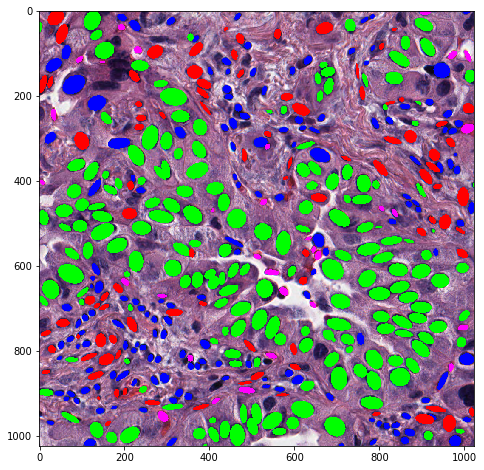

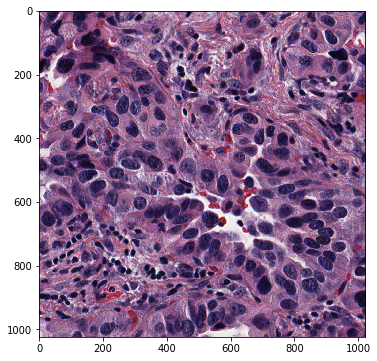

In [19]:
# Reconstruct segmentation
h, w = 1024, 1024
# mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolors = np.array([[0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 0, 255], [255, 255, 0], [0, 255, 255]])
roi_pred_image = image.copy()
for index, (_, cell) in enumerate(patch_summary.iterrows()):
    y, x = skimage.draw.ellipse(cell['coordinate_x'] - patch_coords['coordinate_x'][patch_id], 
                                cell['coordinate_y'] - patch_coords['coordinate_y'][patch_id], 
                                cell['major_axis_length']/2, cell['minor_axis_length']/2, 
                                rotation=-cell['orientation'])
    c = np.logical_and.reduce([x>0, x<h, y>0, y<w])
    x, y = x[c], y[c]
    roi_pred_image[x, y, :] = mycolors[int(cell['cell_type'] - 1)]
    
plt.figure(figsize=(8, 8))
plt.imshow(roi_pred_image)
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

In [20]:
# Calculate and plot risk score
cell_ADC_scores = model_conv3(data.to(device)).detach().cpu().numpy().squeeze()[:, 0]
print(min(cell_ADC_scores), max(cell_ADC_scores))

0.67351043 42.7497


8.3276285e-07 1.0


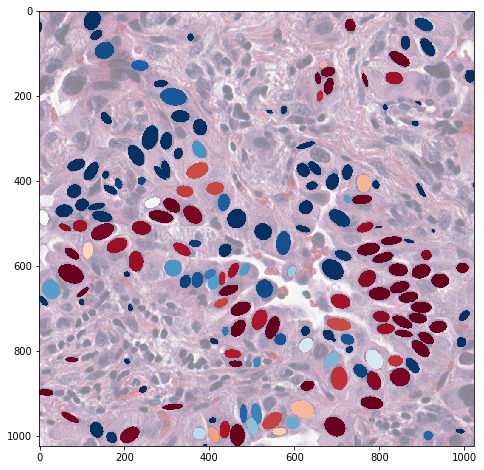

In [21]:
## Plot adc prob.

# Calculate and plot risk score
cell_ADC_scores = torch.softmax(model_conv3(data.to(device)).detach().cpu(), dim=1).numpy().squeeze()[:, 0]
print(min(cell_ADC_scores), max(cell_ADC_scores))

# Set color
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colorbar import ColorbarBase

vmax = 1

norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cmap = cm.RdBu
# cmap = mycmap  # cm.summer
m = cm.ScalarMappable(norm=norm, cmap=cmap)
mycolor_risk = m.to_rgba(cell_ADC_scores)

# Set non-tumor cell types to transparent
mycolor_risk[cell_type != 1, :] = [0, 0, 0, 0]

# Reconstruct segmentation
h, w = 1024, 1024
# mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolors = np.array([[0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 0, 255], [255, 255, 0], [0, 255, 255]])
# roi_pred_image = image.copy()
alpha = 0.5
roi_pred_image = (image * alpha + (np.zeros_like(image).astype(np.uint8) + 255) * (1 - alpha)).astype(np.uint8)
for index, (_, cell) in enumerate(patch_summary.iterrows()):
    if cell['cell_type'] == 1:
        y, x = skimage.draw.ellipse(cell['coordinate_x'] - patch_coords['coordinate_x'][patch_id], 
                                    cell['coordinate_y'] - patch_coords['coordinate_y'][patch_id], 
                                    cell['major_axis_length']/2, cell['minor_axis_length']/2, 
                                    rotation=-cell['orientation'])
        c = np.logical_and.reduce([x>0, x<h, y>0, y<w])
        x, y = x[c], y[c]
        roi_pred_image[x, y, :] = mycolor_risk[index][:3] * 255
    
plt.figure(figsize=(8, 8))
plt.imshow(roi_pred_image)
plt.show()

__Another ADC slide__

In [22]:
pid = 0
i = 0
slide_id = "10021.svs"
patch_id = 80

# Read image patch & nuclei
cell_summary = pd.read_csv(os.path.join(nlst_adc_data_dir, slide_id, "cell_summary_40X_100patches.csv"))
patch_summary = cell_summary[cell_summary['n_patch'] == patch_id]
patch_coords = pd.read_csv(os.path.join(nlst_adc_data_dir, slide_id, "patch_summary_40X_100patches.csv"))

# Plot image
slide_file = os.path.join(nlst_adc_slide_dir, slide_id)
image = extract_patch_by_location(slide_file, 
                                  location=(patch_coords['coordinate_x'][patch_id], 
                                            patch_coords['coordinate_y'][patch_id]),
                                  patch_size=(1024, 1024))
image = np.array(image)[..., :3]

# Plot nuclei
coord_x, coord_y = patch_coords.ix[patch_id, ["coordinate_x", "coordinate_y"]].values
coordinate_x = patch_summary['coordinate_x'] - patch_coords['coordinate_x'][patch_id]
coordinate_y = patch_summary['coordinate_y'] - patch_coords['coordinate_y'][patch_id]

mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolor = mycolors[patch_summary['cell_type'] - 1]

# Construct graph data
if len(patch_summary['cell_type'] == 1) < 20:
    raise Exception("Too few tumor cells.")

# Create 8 nearest neighbors graph
graph = skgraph.kneighbors_graph(np.array(patch_summary.loc[:, ['coordinate_x', 'coordinate_y']]), 
                                 n_neighbors=8, mode='distance')
I, J, V = sp.find(graph)
edges = list(zip(I, J, 1/V))
edge_index = np.transpose(np.array(edges)[:, 0:2])
x = (np.array(patch_summary.loc[:, ['area', 'convex_area', 
                                   'eccentricity', 'extent', 'filled_area', 
                                    'major_axis_length', 'minor_axis_length', 'pa_ratio', 
                                    'perimeter', 'probability', 'solidity']]) - x_ave)/x_std
cell_type = np.array(patch_summary['cell_type'])
orientation = np.array(patch_summary['orientation'])

# Edge features
edge_type = list(map(lambda x: get_edge_type(x, cell_type), edges))
nuclei_orientation = list(map(lambda x: get_nuclei_orientation_diff(x, orientation), edges))
edge_attr = np.transpose(np.array([edge_type, nuclei_orientation, 1/V]))

data = NucleiData(x=torch.tensor(x, dtype=torch.float), 
                  cell_type=torch.tensor(cell_type, dtype=torch.long),
                  edge_index=torch.tensor(edge_index, dtype=torch.long),
                  edge_attr=torch.tensor(edge_attr, dtype=torch.float),
                  y=torch.tensor([[0]]),
                  pid=torch.tensor([[i]]),
                  region_id=torch.tensor([[patch_id]]))

# data.x = torch.zeros_like(data.x) + 1

model(data.to(device)).detach().cpu().numpy().squeeze()

/home2/swan15/.conda/envs/mask_rcnn_danni/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


array([11.82694  ,  6.6096354], dtype=float32)

/home2/swan15/.conda/envs/mask_rcnn_danni/lib/python3.6/site-packages/skimage/draw/draw.py:39: RuntimeWarning: invalid value encountered in true_divide
  distances = ((r * cos_alpha + c * sin_alpha) / r_rad) ** 2 \
/home2/swan15/.conda/envs/mask_rcnn_danni/lib/python3.6/site-packages/skimage/draw/draw.py:40: RuntimeWarning: invalid value encountered in true_divide
  + ((r * sin_alpha - c * cos_alpha) / c_rad) ** 2


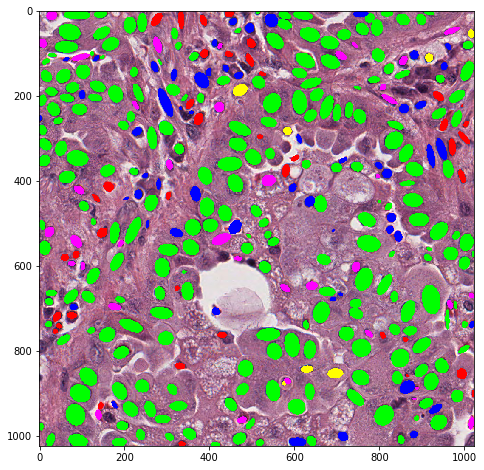

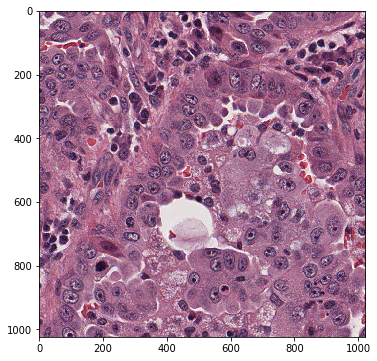

In [23]:
# Reconstruct segmentation
h, w = 1024, 1024
# mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolors = np.array([[0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 0, 255], [255, 255, 0], [0, 255, 255]])
roi_pred_image = image.copy()
for index, (_, cell) in enumerate(patch_summary.iterrows()):
    y, x = skimage.draw.ellipse(cell['coordinate_x'] - patch_coords['coordinate_x'][patch_id], 
                                cell['coordinate_y'] - patch_coords['coordinate_y'][patch_id], 
                                cell['major_axis_length']/2, cell['minor_axis_length']/2, 
                                rotation=-cell['orientation'])
    c = np.logical_and.reduce([x>0, x<h, y>0, y<w])
    x, y = x[c], y[c]
    roi_pred_image[x, y, :] = mycolors[int(cell['cell_type'] - 1)]
    
plt.figure(figsize=(8, 8))
plt.imshow(roi_pred_image)
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

In [24]:
# Calculate and plot risk score
cell_ADC_scores = model_conv3(data.to(device)).detach().cpu().numpy().squeeze()[:, 0]
print(min(cell_ADC_scores), max(cell_ADC_scores))

2.6418545 54.818962


1.7257062e-07 1.0


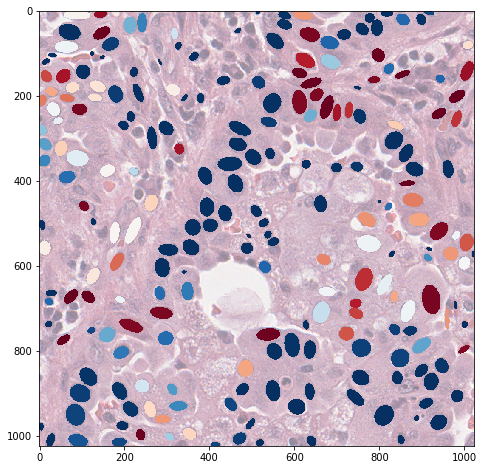

In [25]:
## Plot adc prob.

# Calculate and plot risk score
cell_ADC_scores = torch.softmax(model_conv3(data.to(device)).detach().cpu(), dim=1).numpy().squeeze()[:, 0]
print(min(cell_ADC_scores), max(cell_ADC_scores))

# Set color
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colorbar import ColorbarBase

vmax = 1

norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cmap = cm.RdBu
# cmap = mycmap  # cm.summer
m = cm.ScalarMappable(norm=norm, cmap=cmap)
mycolor_risk = m.to_rgba(cell_ADC_scores)

# Set non-tumor cell types to transparent
mycolor_risk[cell_type != 1, :] = [0, 0, 0, 0]

# Reconstruct segmentation
h, w = 1024, 1024
# mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolors = np.array([[0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 0, 255], [255, 255, 0], [0, 255, 255]])
# roi_pred_image = image.copy()
alpha = 0.5
roi_pred_image = (image * alpha + (np.zeros_like(image).astype(np.uint8) + 255) * (1 - alpha)).astype(np.uint8)
for index, (_, cell) in enumerate(patch_summary.iterrows()):
    if cell['cell_type'] == 1:
        y, x = skimage.draw.ellipse(cell['coordinate_x'] - patch_coords['coordinate_x'][patch_id], 
                                    cell['coordinate_y'] - patch_coords['coordinate_y'][patch_id], 
                                    cell['major_axis_length']/2, cell['minor_axis_length']/2, 
                                    rotation=-cell['orientation'])
        c = np.logical_and.reduce([x>0, x<h, y>0, y<w])
        x, y = x[c], y[c]
        roi_pred_image[x, y, :] = mycolor_risk[index][:3] * 255
    
plt.figure(figsize=(8, 8))
plt.imshow(roi_pred_image)
plt.show()

### Another SCC slide

In [26]:
slide_file = os.path.join(tcga_scc_slide_dir, "TCGA-43-3394-01Z-00-DX1.4c2f49b9-9dac-41d8-a62b-64c8928caa3c.svs")
slide_id = slide_file.split("/")[-1]
patch_id = 70
patch_coords = pd.read_csv("/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/nuclei_segmentation/output/TCGA_LUSC_100_patches/TCGA-43-3394-01Z-00-DX1.4c2f49b9-9dac-41d8-a62b-64c8928caa3c.svs/patch_summary_40X_100patches.csv")
centroids = pd.read_csv("/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/nuclei_segmentation/output/TCGA_LUSC_100_patches/TCGA-43-3394-01Z-00-DX1.4c2f49b9-9dac-41d8-a62b-64c8928caa3c.svs/cell_summary_40X_100patches.csv")
patch_summary = centroids[centroids['which_patch'] == patch_id]
i = 0

# Plot image
image = extract_patch_by_location(slide_file, 
                                  location=(patch_coords['coordinate_x'][patch_id], 
                                            patch_coords['coordinate_y'][patch_id]),
                                  patch_size=(1024, 1024))
image = np.array(image)[..., :3]

# Plot nuclei
coord_x, coord_y = patch_coords.ix[patch_id, ["coordinate_x", "coordinate_y"]].values
coordinate_x = patch_summary['coordinate_x'] - patch_coords['coordinate_x'][patch_id]
coordinate_y = patch_summary['coordinate_y'] - patch_coords['coordinate_y'][patch_id]

mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolor = mycolors[patch_summary['cell_type'] - 1]

# Construct graph data
if len(patch_summary['cell_type']) < 20:
    raise Exception("Too few tumor cells.")

# Create 8 nearest neighbors graph
graph = skgraph.kneighbors_graph(np.array(patch_summary.loc[:, ['coordinate_x', 'coordinate_y']]), 
                                 n_neighbors=8, mode='distance')
I, J, V = sp.find(graph)
edges = list(zip(I, J, 1/V))
edge_index = np.transpose(np.array(edges)[:, 0:2])
x = (np.array(patch_summary.loc[:, ['area', 'convex_area', 
                                   'eccentricity', 'extent', 'filled_area', 
                                    'major_axis_length', 'minor_axis_length', 'pa_ratio', 
                                    'perimeter', 'probability', 'solidity']]) - x_ave)/x_std
cell_type = np.array(patch_summary['cell_type'])
orientation = np.array(patch_summary['orientation'])

# Edge features
edge_type = list(map(lambda x: get_edge_type(x, cell_type), edges))
nuclei_orientation = list(map(lambda x: get_nuclei_orientation_diff(x, orientation), edges))
edge_attr = np.transpose(np.array([edge_type, nuclei_orientation, 1/V]))

data = NucleiData(x=torch.tensor(x, dtype=torch.float), 
                  cell_type=torch.tensor(cell_type, dtype=torch.long),
                  edge_index=torch.tensor(edge_index, dtype=torch.long),
                  edge_attr=torch.tensor(edge_attr, dtype=torch.float),
                  y=torch.tensor([[0]]),
                  pid=torch.tensor([[i]]),
                  region_id=torch.tensor([[patch_id]]))

# data.x = torch.zeros_like(data.x) + 1

model(data.to(device)).detach().cpu().numpy().squeeze()

/home2/swan15/.conda/envs/mask_rcnn_danni/lib/python3.6/site-packages/ipykernel/__main__.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


array([ 7.187099, 10.720511], dtype=float32)

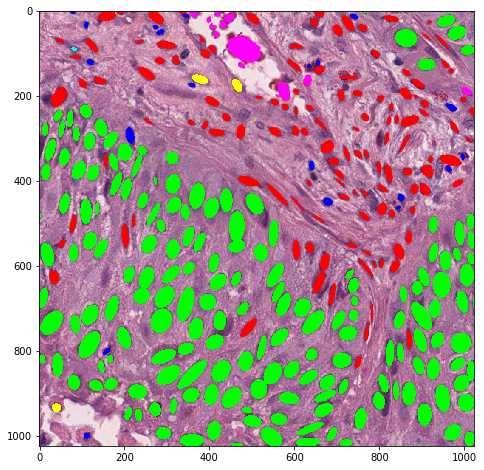

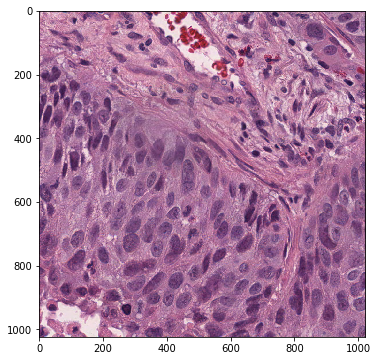

In [27]:
# Reconstruct segmentation
h, w = 1024, 1024
# mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolors = np.array([[0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 0, 255], [255, 255, 0], [0, 255, 255]])
roi_pred_image = image.copy()
for index, (_, cell) in enumerate(patch_summary.iterrows()):
    y, x = skimage.draw.ellipse(cell['coordinate_x'] - patch_coords['coordinate_x'][patch_id], 
                                cell['coordinate_y'] - patch_coords['coordinate_y'][patch_id], 
                                cell['major_axis_length']/2, cell['minor_axis_length']/2, 
                                rotation=-cell['orientation'])
    c = np.logical_and.reduce([x>0, x<h, y>0, y<w])
    x, y = x[c], y[c]
    roi_pred_image[x, y, :] = mycolors[int(cell['cell_type'] - 1)]
    
plt.figure(figsize=(8, 8))
plt.imshow(roi_pred_image)
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

In [28]:
# Calculate and plot risk score
cell_ADC_scores = model_conv3(data.to(device)).detach().cpu().numpy().squeeze()[:, 0]
print(min(cell_ADC_scores), max(cell_ADC_scores))

0.0 44.407845


5.6350583e-08 1.0


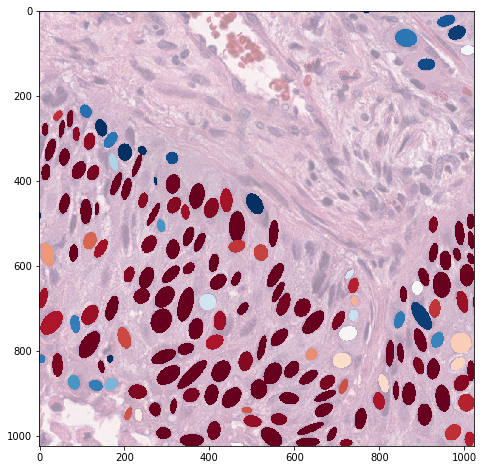

In [29]:
## Plot adc prob.

# Calculate and plot risk score
cell_ADC_scores = torch.softmax(model_conv3(data.to(device)).detach().cpu(), dim=1).numpy().squeeze()[:, 0]
print(min(cell_ADC_scores), max(cell_ADC_scores))

# Set color
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colorbar import ColorbarBase

vmax = 1

norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cmap = cm.RdBu
# cmap = mycmap  # cm.summer
m = cm.ScalarMappable(norm=norm, cmap=cmap)
mycolor_risk = m.to_rgba(cell_ADC_scores)

# Set non-tumor cell types to transparent
mycolor_risk[cell_type != 1, :] = [0, 0, 0, 0]

# Reconstruct segmentation
h, w = 1024, 1024
# mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolors = np.array([[0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 0, 255], [255, 255, 0], [0, 255, 255]])
# roi_pred_image = image.copy()
alpha = 0.5
roi_pred_image = (image * alpha + (np.zeros_like(image).astype(np.uint8) + 255) * (1 - alpha)).astype(np.uint8)
for index, (_, cell) in enumerate(patch_summary.iterrows()):
    if cell['cell_type'] == 1:
        y, x = skimage.draw.ellipse(cell['coordinate_x'] - patch_coords['coordinate_x'][patch_id], 
                                    cell['coordinate_y'] - patch_coords['coordinate_y'][patch_id], 
                                    cell['major_axis_length']/2, cell['minor_axis_length']/2, 
                                    rotation=-cell['orientation'])
        c = np.logical_and.reduce([x>0, x<h, y>0, y<w])
        x, y = x[c], y[c]
        roi_pred_image[x, y, :] = mycolor_risk[index][:3] * 255
    
plt.figure(figsize=(8, 8))
plt.imshow(roi_pred_image)
plt.show()

### Another SCC slide

In [30]:
pid = 0
i = 0
slide_id = "9399.svs"
patch_id = 10

# Read image patch & nuclei
cell_summary = pd.read_csv(os.path.join(nlst_scc_data_dir, slide_id, "cell_summary_40X_100patches.csv"))
patch_summary = cell_summary[cell_summary['which_patch'] == patch_id]
patch_coords = pd.read_csv(os.path.join(nlst_scc_data_dir, slide_id, "patch_summary_40X_100patches.csv"))


# Plot image
slide_file = os.path.join(nlst_scc_slide_dir, slide_id)
image = extract_patch_by_location(slide_file, 
                                  location=(patch_coords['coordinate_x'][patch_id], 
                                            patch_coords['coordinate_y'][patch_id]),
                                  patch_size=(1024, 1024))
image = np.array(image)[..., :3]

# Plot nuclei
coord_x, coord_y = patch_coords.ix[patch_id, ["coordinate_x", "coordinate_y"]].values
coordinate_x = patch_summary['coordinate_x'] - patch_coords['coordinate_x'][patch_id]
coordinate_y = patch_summary['coordinate_y'] - patch_coords['coordinate_y'][patch_id]

mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolor = mycolors[patch_summary['cell_type'] - 1]

# Construct graph data
if len(patch_summary['cell_type']) < 20:
    raise Exception("Too few tumor cells.")

# Create 8 nearest neighbors graph
graph = skgraph.kneighbors_graph(np.array(patch_summary.loc[:, ['coordinate_x', 'coordinate_y']]), 
                                 n_neighbors=8, mode='distance')
I, J, V = sp.find(graph)
edges = list(zip(I, J, 1/V))
edge_index = np.transpose(np.array(edges)[:, 0:2])
x = (np.array(patch_summary.loc[:, ['area', 'convex_area', 
                                   'eccentricity', 'extent', 'filled_area', 
                                    'major_axis_length', 'minor_axis_length', 'pa_ratio', 
                                    'perimeter', 'probability', 'solidity']]) - x_ave)/x_std
cell_type = np.array(patch_summary['cell_type'])
orientation = np.array(patch_summary['orientation'])

# Edge features
edge_type = list(map(lambda x: get_edge_type(x, cell_type), edges))
nuclei_orientation = list(map(lambda x: get_nuclei_orientation_diff(x, orientation), edges))
edge_attr = np.transpose(np.array([edge_type, nuclei_orientation, 1/V]))

data = NucleiData(x=torch.tensor(x, dtype=torch.float), 
                  cell_type=torch.tensor(cell_type, dtype=torch.long),
                  edge_index=torch.tensor(edge_index, dtype=torch.long),
                  edge_attr=torch.tensor(edge_attr, dtype=torch.float),
                  y=torch.tensor([[0]]),
                  pid=torch.tensor([[i]]),
                  region_id=torch.tensor([[patch_id]]))

# data.x = torch.zeros_like(data.x) + 1

model(data.to(device)).detach().cpu().numpy().squeeze()

/home2/swan15/.conda/envs/mask_rcnn_danni/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


array([5.7613935, 9.322551 ], dtype=float32)

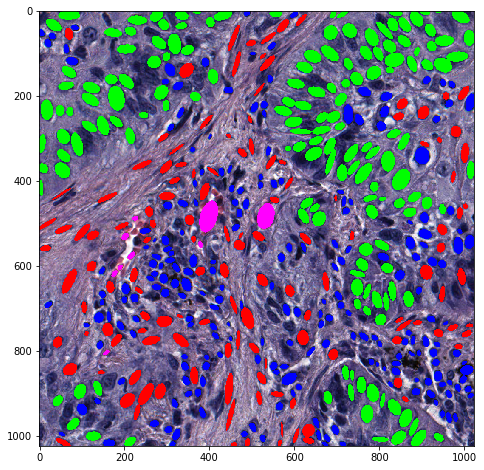

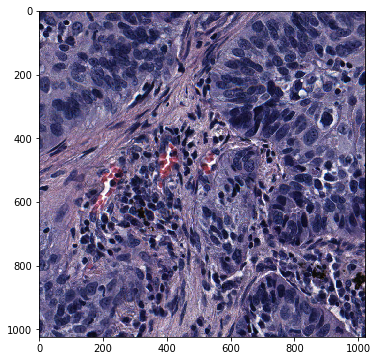

In [31]:
# Reconstruct segmentation
h, w = 1024, 1024
# mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolors = np.array([[0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 0, 255], [255, 255, 0], [0, 255, 255]])
roi_pred_image = image.copy()
for index, (_, cell) in enumerate(patch_summary.iterrows()):
    y, x = skimage.draw.ellipse(cell['coordinate_x'] - patch_coords['coordinate_x'][patch_id], 
                                cell['coordinate_y'] - patch_coords['coordinate_y'][patch_id], 
                                cell['major_axis_length']/2, cell['minor_axis_length']/2, 
                                rotation=-cell['orientation'])
    c = np.logical_and.reduce([x>0, x<h, y>0, y<w])
    x, y = x[c], y[c]
    roi_pred_image[x, y, :] = mycolors[int(cell['cell_type'] - 1)]
    
plt.figure(figsize=(8, 8))
plt.imshow(roi_pred_image)
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

In [32]:
# Calculate and plot risk score
cell_ADC_scores = model_conv3(data.to(device)).detach().cpu().numpy().squeeze()[:, 0]
print(min(cell_ADC_scores), max(cell_ADC_scores))

0.0 37.269817


2.3621432e-08 1.0


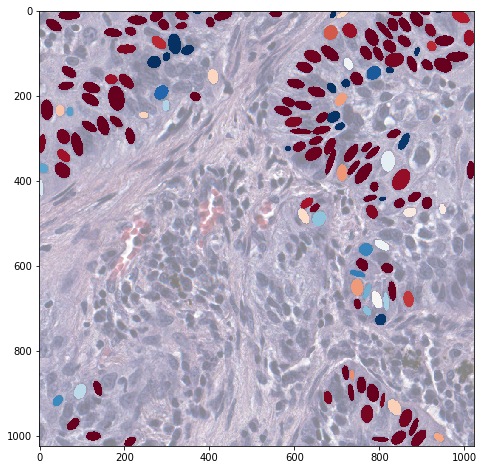

In [33]:
## Plot adc prob.

# Calculate and plot risk score
cell_ADC_scores = torch.softmax(model_conv3(data.to(device)).detach().cpu(), dim=1).numpy().squeeze()[:, 0]
print(min(cell_ADC_scores), max(cell_ADC_scores))

# Set color
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colorbar import ColorbarBase

vmax = 1

norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cmap = cm.RdBu
# cmap = mycmap  # cm.summer
m = cm.ScalarMappable(norm=norm, cmap=cmap)
mycolor_risk = m.to_rgba(cell_ADC_scores)

# Set non-tumor cell types to transparent
mycolor_risk[cell_type != 1, :] = [0, 0, 0, 0]

# Reconstruct segmentation
h, w = 1024, 1024
# mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolors = np.array([[0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 0, 255], [255, 255, 0], [0, 255, 255]])
# roi_pred_image = image.copy()
alpha = 0.5
roi_pred_image = (image * alpha + (np.zeros_like(image).astype(np.uint8) + 255) * (1 - alpha)).astype(np.uint8)
for index, (_, cell) in enumerate(patch_summary.iterrows()):
    if cell['cell_type'] == 1:
        y, x = skimage.draw.ellipse(cell['coordinate_x'] - patch_coords['coordinate_x'][patch_id], 
                                    cell['coordinate_y'] - patch_coords['coordinate_y'][patch_id], 
                                    cell['major_axis_length']/2, cell['minor_axis_length']/2, 
                                    rotation=-cell['orientation'])
        c = np.logical_and.reduce([x>0, x<h, y>0, y<w])
        x, y = x[c], y[c]
        roi_pred_image[x, y, :] = mycolor_risk[index][:3] * 255
    
plt.figure(figsize=(8, 8))
plt.imshow(roi_pred_image)
plt.show()

### Another SCC slide

In [34]:
pid = 0
i = 0
slide_id = "11791.svs"
patch_id = 80

# Read image patch & nuclei
cell_summary = pd.read_csv(os.path.join(nlst_scc_data_dir, slide_id, "cell_summary_40X_100patches.csv"))
patch_summary = cell_summary[cell_summary['which_patch'] == patch_id]
patch_coords = pd.read_csv(os.path.join(nlst_scc_data_dir, slide_id, "patch_summary_40X_100patches.csv"))


# Plot image
slide_file = os.path.join(nlst_scc_slide_dir, slide_id)
image = extract_patch_by_location(slide_file, 
                                  location=(patch_coords['coordinate_x'][patch_id], 
                                            patch_coords['coordinate_y'][patch_id]),
                                  patch_size=(1024, 1024))
image = np.array(image)[..., :3]

# Plot nuclei
coord_x, coord_y = patch_coords.ix[patch_id, ["coordinate_x", "coordinate_y"]].values
coordinate_x = patch_summary['coordinate_x'] - patch_coords['coordinate_x'][patch_id]
coordinate_y = patch_summary['coordinate_y'] - patch_coords['coordinate_y'][patch_id]

mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolor = mycolors[patch_summary['cell_type'] - 1]

# Construct graph data
if len(patch_summary['cell_type']) < 20:
    raise Exception("Too few tumor cells.")

# Create 8 nearest neighbors graph
graph = skgraph.kneighbors_graph(np.array(patch_summary.loc[:, ['coordinate_x', 'coordinate_y']]), 
                                 n_neighbors=8, mode='distance')
I, J, V = sp.find(graph)
edges = list(zip(I, J, 1/V))
edge_index = np.transpose(np.array(edges)[:, 0:2])
x = (np.array(patch_summary.loc[:, ['area', 'convex_area', 
                                   'eccentricity', 'extent', 'filled_area', 
                                    'major_axis_length', 'minor_axis_length', 'pa_ratio', 
                                    'perimeter', 'probability', 'solidity']]) - x_ave)/x_std
cell_type = np.array(patch_summary['cell_type'])
orientation = np.array(patch_summary['orientation'])

# Edge features
edge_type = list(map(lambda x: get_edge_type(x, cell_type), edges))
nuclei_orientation = list(map(lambda x: get_nuclei_orientation_diff(x, orientation), edges))
edge_attr = np.transpose(np.array([edge_type, nuclei_orientation, 1/V]))

data = NucleiData(x=torch.tensor(x, dtype=torch.float), 
                  cell_type=torch.tensor(cell_type, dtype=torch.long),
                  edge_index=torch.tensor(edge_index, dtype=torch.long),
                  edge_attr=torch.tensor(edge_attr, dtype=torch.float),
                  y=torch.tensor([[0]]),
                  pid=torch.tensor([[i]]),
                  region_id=torch.tensor([[patch_id]]))

# data.x = torch.zeros_like(data.x) + 1

model(data.to(device)).detach().cpu().numpy().squeeze()

/home2/swan15/.conda/envs/mask_rcnn_danni/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


array([10.919943, 12.76223 ], dtype=float32)

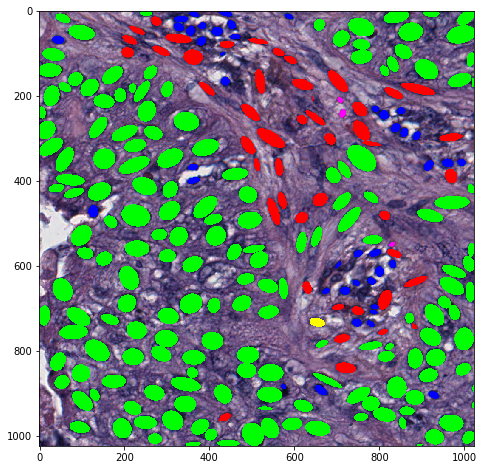

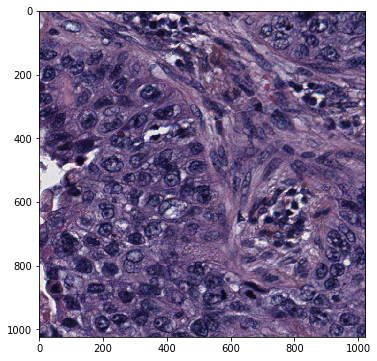

In [35]:
# Reconstruct segmentation
h, w = 1024, 1024
# mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolors = np.array([[0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 0, 255], [255, 255, 0], [0, 255, 255]])
roi_pred_image = image.copy()
for index, (_, cell) in enumerate(patch_summary.iterrows()):
    y, x = skimage.draw.ellipse(cell['coordinate_x'] - patch_coords['coordinate_x'][patch_id], 
                                cell['coordinate_y'] - patch_coords['coordinate_y'][patch_id], 
                                cell['major_axis_length']/2, cell['minor_axis_length']/2, 
                                rotation=-cell['orientation'])
    c = np.logical_and.reduce([x>0, x<h, y>0, y<w])
    x, y = x[c], y[c]
    roi_pred_image[x, y, :] = mycolors[int(cell['cell_type'] - 1)]
    
plt.figure(figsize=(8, 8))
plt.imshow(roi_pred_image)
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()

In [36]:
# Calculate and plot risk score
cell_ADC_scores = model_conv3(data.to(device)).detach().cpu().numpy().squeeze()[:, 0]
print(min(cell_ADC_scores), max(cell_ADC_scores))

3.1893377 52.09913


6.7033056e-07 1.0


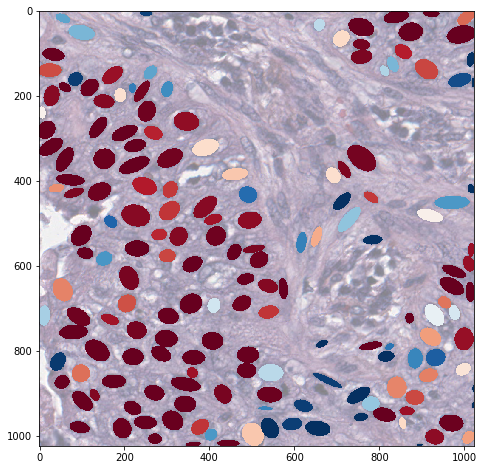

In [37]:
## Plot adc prob.

# Calculate and plot risk score
cell_ADC_scores = torch.softmax(model_conv3(data.to(device)).detach().cpu(), dim=1).numpy().squeeze()[:, 0]
print(min(cell_ADC_scores), max(cell_ADC_scores))

# Set color
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colorbar import ColorbarBase

vmax = 1

norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cmap = cm.RdBu
# cmap = mycmap  # cm.summer
m = cm.ScalarMappable(norm=norm, cmap=cmap)
mycolor_risk = m.to_rgba(cell_ADC_scores)

# Set non-tumor cell types to transparent
mycolor_risk[cell_type != 1, :] = [0, 0, 0, 0]

# Reconstruct segmentation
h, w = 1024, 1024
# mycolors = np.array(["lime", "red", "blue", "magenta", "yellow", "cyan"])
mycolors = np.array([[0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 0, 255], [255, 255, 0], [0, 255, 255]])
# roi_pred_image = image.copy()
alpha = 0.5
roi_pred_image = (image * alpha + (np.zeros_like(image).astype(np.uint8) + 255) * (1 - alpha)).astype(np.uint8)
for index, (_, cell) in enumerate(patch_summary.iterrows()):
    if cell['cell_type'] == 1:
        y, x = skimage.draw.ellipse(cell['coordinate_x'] - patch_coords['coordinate_x'][patch_id], 
                                    cell['coordinate_y'] - patch_coords['coordinate_y'][patch_id], 
                                    cell['major_axis_length']/2, cell['minor_axis_length']/2, 
                                    rotation=-cell['orientation'])
        c = np.logical_and.reduce([x>0, x<h, y>0, y<w])
        x, y = x[c], y[c]
        roi_pred_image[x, y, :] = mycolor_risk[index][:3] * 255
    
plt.figure(figsize=(8, 8))
plt.imshow(roi_pred_image)
plt.show()

# Session Info

In [57]:
!pip freeze

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
absl-py==0.7.0
altair==3.2.0
anndata==0.7.8
argh==0.26.2
ase==3.21.1
astor==0.7.1
astropy==3.2.1
atomicwrites==1.3.0
attrs==19.1.0
autograd==1.2
backcall==0.1.0
base58==1.0.3
bleach==3.1.0
blinker==1.4
Bottleneck==1.2.1
certifi==2019.3.9
chardet==3.0.4
Click==7.0
cvxopt==1.2.3
cvxpy==1.0.24
cycler==0.10.0
decorator==4.4.0
defusedxml==0.5.0
dill==0.2.9
docutils==0.15.2
ecos==2.0.7.post1
entrypoints==0.3
enum-compat==0.0.3
environment-kernels==1.1.1
FITS-tools==0.2
future==0.17.1
gast==0.2.2
googledrivedownloader==0.4
grpcio==1.16.0
h5py==2.10.0
image-registration==0.2.4
imagecodecs==2020.5.30
imageio==2.6.1
importlib-metadata==0.23
importlib-resources==5.4.0
ipykernel==5.1.0
ipython==7.4.0
ipython-genutils==0.2.0
ipywidgets==7.4.2
isodate==0.6.0
jedi==0.13.3
Jinja2==2.10.1
jmespath==0.9.4
joblib==1.1.0
js